In [1]:
import os
import torch
import scipy.io
import torch.nn as nn  # Import nn module
import torch.optim as optim  # Import optim module
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import matplotlib.pyplot as plt
from hyperspectral_dataset import HyperspectralDataset, CustomTransform
from rgb_dataset import RGBDataset
from torchvision.transforms import Resize, CenterCrop, Compose, Normalize, ToTensor
from transformer import TransformerMod



from ResNet import CustomResNet50  # Assuming ResNet50 is defined in ResNet.py
import torch
print(torch.cuda.is_available())  # Should return True
print(torch.cuda.get_device_name(0))  # Should print the name of your GPU
# Check for CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Create a random tensor and move it to the GPU
x = torch.rand(10000, 10000).to(device)
y = torch.rand(10000, 10000).to(device)

# Perform a matrix multiplication on the GPU
z = torch.matmul(x, y)

print("Matrix multiplication result:", z)
print("Done.")



Original x:  tensor([ 1.4867, -2.1896,  1.0046,  1.2336, -0.6229, -0.5235,  1.0352, -0.1280,
         0.3379,  0.4991])
Reconstructed x:  tensor([ 1.4867, -2.1896,  1.0046,  1.2336, -0.6229, -0.5235,  1.0352, -0.1280,
         0.3379,  0.4991])
Difference:  tensor(4.1107e-07)
True
NVIDIA GeForce RTX 4070
Using device: cuda
Using device: cuda
Matrix multiplication result: tensor([[2502.3164, 2507.6965, 2498.1414,  ..., 2494.9377, 2498.4883,
         2492.2185],
        [2514.3240, 2524.4685, 2523.4099,  ..., 2505.9722, 2518.2292,
         2510.0010],
        [2514.1960, 2524.8345, 2514.3245,  ..., 2508.8447, 2519.0286,
         2501.7534],
        ...,
        [2511.6997, 2507.5261, 2499.0759,  ..., 2492.7690, 2496.7178,
         2497.8655],
        [2522.7412, 2517.7324, 2525.6572,  ..., 2509.9338, 2507.9102,
         2503.5623],
        [2528.0825, 2519.8113, 2507.5920,  ..., 2511.5505, 2499.3867,
         2515.5847]], device='cuda:0')
Done.


In [2]:
# # Function to get all file paths from a dataset
# def get_all_file_paths(dataset):
#     file_paths = []
#     # for idx in range(len(dataset)):
#     file_paths.append(dataset.get_image_path(idx))
#     return file_paths

# # # Initialize the dataset with transformations
# # dataset = RGBDataset(root_dir='../../../serverstuff/hsi/all')
# # channel_means_cube, channel_stds_cube, channel_means_profile, channel_stds_profile = compute_statistics(dataset)

# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
# ])

# # Apply the custom transforms to the datasets
# train_dataset = RGBDataset(root_dir='../../../serverstuff/hsi/train', transform=transform)
# val_dataset = RGBDataset(root_dir='../../../serverstuff/hsi/validation', transform=transform)
# test_dataset = RGBDataset(root_dir='../../../serverstuff/hsi/test', transform=transform)

# # Create DataLoaders for training, validation, and test sets
# train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
# val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)
# test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=4)

In [3]:
import torch
from torch.utils.data import DataLoader

# Function to get all file paths from a dataset
def get_all_file_paths(dataset):
    file_paths = []
    for idx in range(len(dataset)):
        file_paths.append(dataset.get_image_path(idx))
    return file_paths

# Initialize the dataset with transformations
dataset = HyperspectralDataset(root_dir='../../dibasRP/all')

# Define mean and std for cube and profile (replace these with actual values if available)
channel_means_cube = [0.5] * 31
channel_stds_cube = [0.5] * 31
channel_means_profile = [0.5] * 31
channel_stds_profile = [0.5] * 31

# Define the custom transformation including normalization and resizing
custom_transform = CustomTransform(
    cube_mean=channel_means_cube, 
    cube_std=channel_stds_cube, 
    profile_mean=channel_means_profile, 
    profile_std=channel_stds_profile,
    resize_shape=(224, 224)  # Resize cube to 224x224
)

# Apply the custom transforms to the datasets
train_dataset = HyperspectralDataset(root_dir='../../dibasRP/train', transform=custom_transform)
val_dataset = HyperspectralDataset(root_dir='../../dibasRP/val', transform=custom_transform)
test_dataset = HyperspectralDataset(root_dir='../../dibasRP/test', transform=custom_transform)

# Create DataLoaders for training, validation, and test sets
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=4)

# Example to verify the changes
for sample, label in train_loader:
    print(f"Cube shape: {sample['cube'].shape}, Profile shape: {sample['profile'].shape}, Label: {label}")
    break

Label mapping: {'Acinetobacter_baumanii': 0, 'Lactobacillus_casei': 1, 'Lactobacillus_jehnsenii': 2, 'Lactobacillus_gasseri': 3, 'Lactobacillus_delbrueckii': 4, 'Lactobacillus_salivarius': 5, 'Propionibacterium_acnes': 6, 'Lactobacillus_paracasei': 7, 'Bifidobacterium_spp': 8, 'Lactobacillus_reuteri': 9, 'Staphylococcus_aureus': 10, 'Escherichia_coli': 11, 'Lactobacillus_rhamnosus': 12, 'Lactobacillus_plantarum': 13, 'Enterococcus_faecium': 14, 'Porfyromonas_gingivalis': 15, 'Enterococcus_faecalis': 16, 'Micrococcus_spp': 17, 'Fusobacterium': 18, 'Actinomyces_israeli': 19, 'Lactobacillus_crispatus': 20, 'Clostridium_perfringens': 21, 'Staphylococcus_epidermidis': 22, 'Listeria_monocytogenes': 23, 'Pseudomonas_aeruginosa': 24, 'Lactobacillus_johnsonii': 25, 'Streptococcus_agalactiae': 26, 'Staphylococcus_saprophiticus': 27, 'Bacteroides_fragilis': 28, 'Neisseria_gonorrhoeae': 29, 'Veionella': 30, 'Proteus': 31, 'Candida_albicans': 32}
Label mapping: {'Acinetobacter_baumanii': 0, 'Lactob

In [4]:
# # Get file paths for the main dataset and each split
# main_dataset_paths = get_all_file_paths(dataset)
# train_dataset_paths = get_all_file_paths(train_dataset)
# val_dataset_paths = get_all_file_paths(val_dataset)
# test_dataset_paths = get_all_file_paths(test_dataset)

# # Check if the total length of the splits equals the length of the main dataset
# total_split_length = len(train_dataset_paths) + len(val_dataset_paths) + len(test_dataset_paths)
# if total_split_length != len(main_dataset_paths):
#     print(f"Error: Total length of splits ({total_split_length}) does not equal length of main dataset ({len(main_dataset_paths)})")
# else:
#     print("Total length of splits matches the length of the main dataset.")

# # Check for overlaps between splits
# def check_for_overlaps(paths1, paths2):
#     overlaps = set(paths1) & set(paths2)
#     return overlaps

# train_val_overlaps = check_for_overlaps(train_dataset_paths, val_dataset_paths)
# train_test_overlaps = check_for_overlaps(train_dataset_paths, test_dataset_paths)
# val_test_overlaps = check_for_overlaps(val_dataset_paths, test_dataset_paths)

# if train_val_overlaps:
#     print(f"Error: Overlaps found between train and validation datasets: {len(train_val_overlaps)} overlaps")
# else:
#     print("No overlaps found between train and validation datasets.")

# if train_test_overlaps:
#     print(f"Error: Overlaps found between train and test datasets: {len(train_test_overlaps)} overlaps")
# else:
#     print("No overlaps found between train and test datasets.")

# if val_test_overlaps:
#     print(f"Error: Overlaps found between validation and test datasets: {len(val_test_overlaps)} overlaps")
# else:
#     print("No overlaps found between validation and test datasets.")

In [5]:
# Initialize the modified ResNet model

model = TransformerMod(num_classes=len(train_dataset.label_map)).to(device)

# model = CustomResNet50(num_classes=len(train_dataset.label_map)).to(device)
# model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1).to(device)

# Replace the classifier layer with a new one
#model.classifier = nn.Linear(num_features, 34).to(device)  # Assuming 10 classes

#print(model.classifier.out_features)


for name, param in model.named_parameters():
    print(f"{name}: {'requires_grad' if param.requires_grad else 'frozen'}")


customtransformer.vit.embeddings.cls_token: frozen
customtransformer.vit.embeddings.position_embeddings: frozen
customtransformer.vit.embeddings.patch_embeddings.projection.weight: frozen
customtransformer.vit.embeddings.patch_embeddings.projection.bias: frozen
customtransformer.vit.encoder.layer.0.attention.attention.query.weight: frozen
customtransformer.vit.encoder.layer.0.attention.attention.query.bias: frozen
customtransformer.vit.encoder.layer.0.attention.attention.key.weight: frozen
customtransformer.vit.encoder.layer.0.attention.attention.key.bias: frozen
customtransformer.vit.encoder.layer.0.attention.attention.value.weight: frozen
customtransformer.vit.encoder.layer.0.attention.attention.value.bias: frozen
customtransformer.vit.encoder.layer.0.attention.output.dense.weight: frozen
customtransformer.vit.encoder.layer.0.attention.output.dense.bias: frozen
customtransformer.vit.encoder.layer.0.intermediate.dense.weight: frozen
customtransformer.vit.encoder.layer.0.intermediate.d

In [6]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)
# optimizer = optim.Adam(model.parameters(), lr=0.001)

optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.5, patience=5)



In [7]:
import time
from sklearn.metrics import precision_recall_fscore_support

# Initialize lists to store losses, accuracy, and learning rate change epochs
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
train_precisions = []
train_recalls = []
train_f1_scores = []
val_precisions = []
val_recalls = []
val_f1_scores = []
lr_change_epochs = []

# Training and validation loop
num_epochs = 125  # Set the number of epochs
for epoch in range(num_epochs):
    epoch_start_time = time.time()  # Start timing the epoch

    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    all_train_labels = []
    all_train_preds = []

    for batch_idx, (sample, labels) in enumerate(train_loader):
        cubes, profiles = sample['cube'], sample['profile']  # Extract cube and profile from the dictionary
        cubes, profiles, labels = cubes.to(device), profiles.to(device), labels.to(device)  # Move data to GPU
        optimizer.zero_grad()  # Zero the parameter gradients

        # Forward pass
        outputs = model(cubes)
        loss = criterion(outputs.logits, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.logits, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        # Store labels and predictions for precision, recall, f1
        all_train_labels.extend(labels.cpu().numpy())
        all_train_preds.extend(predicted.cpu().numpy())

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)

    # Calculate precision, recall, f1 score for training
    train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(all_train_labels, all_train_preds, average='weighted', zero_division=0)
    train_precisions.append(train_precision)
    train_recalls.append(train_recall)
    train_f1_scores.append(train_f1)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Precision: {train_precision:.3f}, Recall: {train_recall:.3f}, F1 Score: {train_f1:.3f}")

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    all_val_labels = []
    all_val_preds = []

    with torch.no_grad():
        for sample, labels in val_loader:
            cubes, profiles = sample['cube'], sample['profile']  # Extract cube and profile from the dictionary
            cubes, profiles, labels = cubes.to(device), profiles.to(device), labels.to(device)  # Move data to GPU
            outputs = model(cubes)
            loss = criterion(outputs.logits, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.logits, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

            # Store labels and predictions for precision, recall, f1
            all_val_labels.extend(labels.cpu().numpy())
            all_val_preds.extend(predicted.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)

    # Calculate precision, recall, f1 score for validation
    val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(all_val_labels, all_val_preds, average='weighted', zero_division=0)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_f1_scores.append(val_f1)

    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%, Precision: {val_precision:.3f}, Recall: {val_recall:.3f}, F1 Score: {val_f1:.3f}")

    current_lr = optimizer.param_groups[0]['lr']
    scheduler.step(avg_val_loss)
    new_lr = optimizer.param_groups[0]['lr']
    if new_lr < current_lr:
        print(f"Learning rate reduced from {current_lr} to {new_lr}")
        lr_change_epochs.append(epoch+1)  # Log the epoch where the learning rate changed

    epoch_end_time = time.time()  # End timing the epoch
    epoch_duration = epoch_end_time - epoch_start_time
    print(f"Epoch [{epoch+1}/{num_epochs}] completed in {epoch_duration:.2f} seconds")

print("Training complete.")


Epoch [1/125], Loss: 2.0023, Training Accuracy: 55.60%, Precision: 0.604, Recall: 0.556, F1 Score: 0.565
Validation Loss: 0.8277, Validation Accuracy: 82.89%, Precision: 0.845, Recall: 0.829, F1 Score: 0.813
Epoch [1/125] completed in 5.87 seconds
Epoch [2/125], Loss: 0.5016, Training Accuracy: 88.43%, Precision: 0.888, Recall: 0.884, F1 Score: 0.884
Validation Loss: 0.5813, Validation Accuracy: 86.84%, Precision: 0.883, Recall: 0.868, F1 Score: 0.855
Epoch [2/125] completed in 5.72 seconds
Epoch [3/125], Loss: 0.2212, Training Accuracy: 97.57%, Precision: 0.977, Recall: 0.976, F1 Score: 0.976
Validation Loss: 0.5475, Validation Accuracy: 85.53%, Precision: 0.890, Recall: 0.855, F1 Score: 0.847
Epoch [3/125] completed in 5.65 seconds
Epoch [4/125], Loss: 0.1122, Training Accuracy: 99.25%, Precision: 0.993, Recall: 0.993, F1 Score: 0.992
Validation Loss: 0.4349, Validation Accuracy: 90.79%, Precision: 0.912, Recall: 0.908, F1 Score: 0.896
Epoch [4/125] completed in 5.62 seconds
Epoch [5

KeyboardInterrupt: 

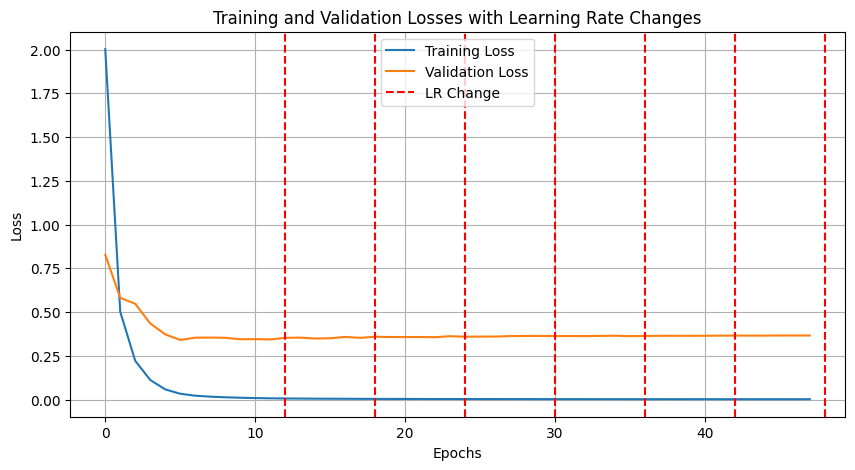

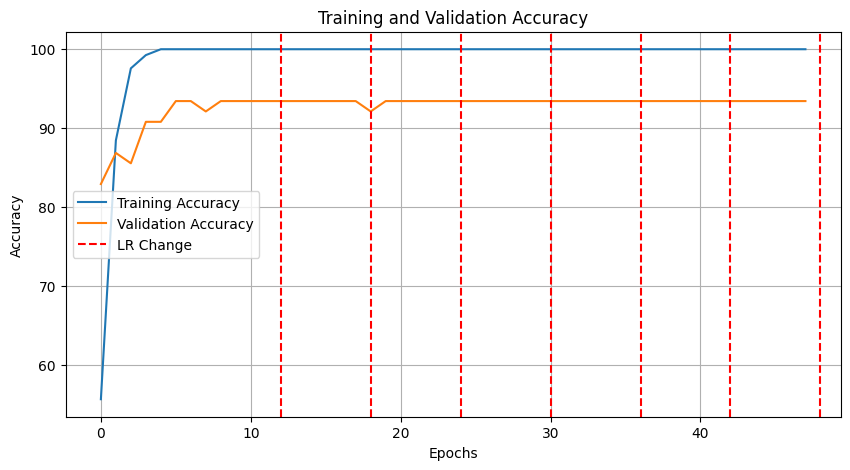

In [8]:
# Plot the training and validation losses with learning rate change points
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
for lr_epoch in lr_change_epochs:
    plt.axvline(x=lr_epoch, color='r', linestyle='--', label='LR Change' if lr_epoch == lr_change_epochs[0] else "")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses with Learning Rate Changes')
plt.grid(True)  # Add gridlines
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
for lr_epoch in lr_change_epochs:
    plt.axvline(x=lr_epoch, color='r', linestyle='--', label='LR Change' if lr_epoch == lr_change_epochs[0] else "")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.grid(True)  # Add gridlines
plt.show()


In [9]:
# Testing loop
model.eval()  # Set the model to evaluation mode
test_loss = 0.0
correct = 0
total = 0 
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs['cube'].to(device), labels.to(device)  # Move data to GPU
        outputs = model(inputs)
        loss = criterion(outputs.logits, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs.logits, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Loss: {test_loss/len(test_loader):.4f}, Test Accuracy: {accuracy:.2f}%")


Test Loss: 0.2023, Test Accuracy: 94.81%


<Figure size 1000x1000 with 0 Axes>

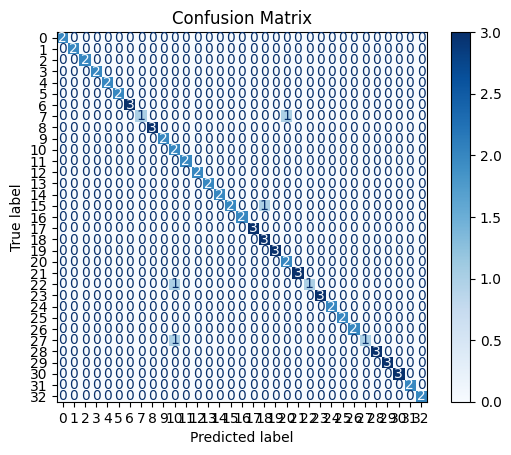

In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Function to test an individual sample and collect predictions and true labels
def test_individual_test_sample(sample_idx, true_labels, predicted_labels):
    # Load a specific sample from the test dataset
    cube, label = test_dataset[sample_idx]
    
    # Move the sample to GPU if using CUDA
    cube = cube['cube'].to(device).unsqueeze(0)  # Add batch dimension
    label = label.to(device)
    
    # Set the model to evaluation mode
    model.eval()
    
    # Disable gradient computation for inference
    with torch.no_grad():
        output = model(cube)
    
    # Apply softmax to get probabilities
    probabilities = torch.nn.functional.softmax(output.logits, dim=1)
    
    # Get the predicted class
    predicted_class = torch.argmax(probabilities, dim=1)
    
    # Append the true and predicted labels to their respective lists
    true_labels.append(label.item())
    predicted_labels.append(predicted_class.item())

# Lists to store true and predicted labels
true_labels = []
predicted_labels = []

# Test individual samples and collect labels
for i in range(len(test_dataset)):
    test_individual_test_sample(i, true_labels, predicted_labels)

# Convert lists to numpy arrays for compatibility with sklearn
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


In [11]:
torch.save(model.state_dict(), 'transformer.pth')

In [12]:
for name, param in model.named_parameters():
    print(name)

customtransformer.vit.embeddings.cls_token
customtransformer.vit.embeddings.position_embeddings
customtransformer.vit.embeddings.patch_embeddings.projection.weight
customtransformer.vit.embeddings.patch_embeddings.projection.bias
customtransformer.vit.encoder.layer.0.attention.attention.query.weight
customtransformer.vit.encoder.layer.0.attention.attention.query.bias
customtransformer.vit.encoder.layer.0.attention.attention.key.weight
customtransformer.vit.encoder.layer.0.attention.attention.key.bias
customtransformer.vit.encoder.layer.0.attention.attention.value.weight
customtransformer.vit.encoder.layer.0.attention.attention.value.bias
customtransformer.vit.encoder.layer.0.attention.output.dense.weight
customtransformer.vit.encoder.layer.0.attention.output.dense.bias
customtransformer.vit.encoder.layer.0.intermediate.dense.weight
customtransformer.vit.encoder.layer.0.intermediate.dense.bias
customtransformer.vit.encoder.layer.0.output.dense.weight
customtransformer.vit.encoder.layer.

In [ ]:
for a, b in enumerate(train_loader):
    print(a,b)